In [56]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
from cmdstanpy import CmdStanModel
import arviz as az

if not os.path.exists('./stan'):
    os.makedirs('./stan')

In [57]:
model_out120 = """

data {
  int<lower=0> N; // Number of observations
  int<lower=0> N_miss; // Number of missing observations
  int<lower=0> P; // Covariate number
  int<lower=0> nyears;
  int<lower=0> nstations;

  array[N] int<lower=0> station;
  array[N] int<lower=0> year;
  array[N] int<lower=0> max_month;

  array[N_miss] int<lower=0> station_miss;
  array[N_miss] int<lower=0> year_miss;
  array[N_miss] int<lower=0> max_month_miss;
  
  array[N] int<lower=0> y; // Count data

  matrix[N, P] X; // Predictor matrix
  matrix[N_miss, P] X_miss; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nstations] eta; // Random effects for comuni
  vector[nyears] xi; // Random effects for years

  //real<lower=0> sigma0; // Standard deviation for beta
  //real<lower=0> sigma1; // Standard deviation for xi
  //real<lower=0> sigma2; // Standard deviation for eta
}

transformed parameters {
    vector[N] lambda;
    vector[N_miss] lambda_miss;

    lambda = exp(xi[year] + eta[station] + X * beta);
    lambda_miss = exp(xi[year_miss] + eta[station_miss] + X_miss * beta);

    /*
    for (i in 1:N) {
      if (lambda[i] > max_month[i]) {
        lambda[i] = max_month[i];
      }
    }

    for (i in 1:N_miss) {
      if (lambda_miss[i] > max_month_miss[i]) {
        lambda_miss[i] = max_month_miss[i];
      }
    }
    */
}

model {
  beta ~ normal(0, 2);
  xi ~ normal(0, 2);
  eta ~ normal(0, 2);

  for (i in 1:N) {
    y[i] ~ poisson(lambda[i]);  // T[0, max_month[i]]
  }
}

generated quantities {
  vector[N] log_lik;
  vector[N] y_pred;
  vector[N_miss] y_pred_miss;

  /*
  for (i in 1:N) {
    real sum_p = 0;
    real u = uniform_rng(0, 1);
    for (b in 0:max_month[i]) {
      sum_p = sum_p + exp(poisson_lpmf(b | lambda[i]) - poisson_lcdf(max_month[i] | lambda[i]));
      if (sum_p >= u) {
        y_pred[i] = b;
        break;
      }
    }
  }
  */

  for(i in 1:N){
    log_lik [ i ] = poisson_lpmf (y[i] | lambda[i]);
    y_pred[i] = poisson_rng(lambda[i]);
  }

  for(i in 1:N_miss){
    y_pred_miss[i] = poisson_rng(lambda_miss[i]);
  }
}

"""

stan_file = "./stan/out120.stan"

with open(stan_file, "w") as f:
    print(model_out120, file=f)

model_out120 = CmdStanModel(stan_file=stan_file)

15:09:40 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\out120.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\out120.exe
15:10:37 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\out120.exe


In [58]:
X = pd.read_csv("../Datasets/covariates.csv")
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y.loc[:,'Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.get_dummies(X ,columns = ['Type'] ,prefix = 'type', drop_first = True)
X.loc[X['Station'] == 10171, 'Quota'] = 10

In [59]:
rows_miss_Y = Y[Y['Count_120'].isna()].index
rows_obs_Y = Y[~Y['Count_120'].isna()].index

# take XX% of the remaining indexes for a test set
XX = 0.5 # [0, 1] change this value to change the size of the test set
rows_test_Y = np.random.choice(rows_obs_Y, int(XX*len(rows_obs_Y)), replace=False)
rows_test_Y.sort()
rows_to_drop_Y = np.concatenate((rows_test_Y, rows_miss_Y))
rows_to_drop_Y.sort()

# Remove corresponding rows from dataset X
X_obs = X.drop(index=rows_to_drop_Y)
Y_obs = Y.drop(index=rows_to_drop_Y)
X_miss = X.loc[rows_to_drop_Y,:]
Y_miss = Y.loc[rows_to_drop_Y,:]

#saving the indexes of the dataframes
X_obs_index = X_obs.index
Y_obs_index = Y_obs.index
X_miss_index = X_miss.index
Y_miss_index = Y_miss.index

# If you want to reset the index after dropping rows
X_obs = X_obs.reset_index(drop=True)
Y_obs = Y_obs.reset_index(drop=True)
X_miss = X_miss.reset_index(drop=True)
Y_miss = Y_miss.reset_index(drop=True)

In [60]:
stations_obs = X_obs.loc[:,'Station']
years_raw_obs = X_obs.loc[:,'Year']
months_raw_obs = X_obs.loc[:,'Month']
years_obs = X_obs.loc[:,'Year'] - 2009
unique_values_obs = sorted(set(stations_obs))
mapping_dict_obs = {value: index + 1 for index, value in enumerate(unique_values_obs)}
transformed_stations_obs = [mapping_dict_obs[value] for value in stations_obs]

transformed_stations_obs = pd.Series(transformed_stations_obs)
years_obs = pd.Series(years_obs)

stations_miss = X_miss.loc[:,'Station']
years_raw_miss = X_miss.loc[:,'Year']
months_raw_miss = X_miss.loc[:,'Month']
years_miss = X_miss.loc[:,'Year'] - 2009
unique_values_miss = sorted(set(stations_miss))
mapping_dict_miss = {value_miss: index_miss + 1 for index_miss, value_miss in enumerate(unique_values_miss)}
transformed_stations_miss = [mapping_dict_miss[value_miss] for value_miss in stations_miss]

transformed_stations_miss = pd.Series(transformed_stations_miss)
years_miss = pd.Series(years_miss)

day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month_tot =[]
max_month_obs = []
max_month_miss = []

for i in range(0,X.shape[0]):
    max_month_tot.append(day_in_month[X['Month'][i]-1])

for i in range(0,X_obs.shape[0]):
    max_month_obs.append(day_in_month[X_obs['Month'][i]-1])

for i in range(0,X_miss.shape[0]):
    max_month_miss.append(day_in_month[X_miss['Month'][i]-1])

max_month_tot = pd.Series(max_month_tot)
max_month_obs = pd.Series(max_month_obs)
max_month_miss = pd.Series(max_month_miss)

In [61]:
X_obs = X_obs.drop(['Year','Station','Month'], axis  = 1)
X_miss = X_miss.drop(['Year','Station','Month'], axis  = 1)

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_obs_std = scaler.fit_transform(X_obs)
X_obs_std = pd.DataFrame(X_obs_std, columns=X_obs.columns)
X_obs_std.loc[:,"type_rural"] = X.loc[:,"type_rural"]
X_obs_std.loc[:,"type_urban"] = X.loc[:,"type_urban"]
X_obs_std.loc[:,"type_rural"] = pd.to_numeric(X_obs_std.loc[:,"type_rural"]).astype('Int64')
X_obs_std.loc[:,"type_urban"] = pd.to_numeric(X_obs_std.loc[:,"type_urban"]).astype('Int64')

X_miss_std = scaler.fit_transform(X_miss)
X_miss_std = pd.DataFrame(X_miss_std, columns=X_miss.columns)
X_miss_std.loc[:,"type_rural"] = X_miss.loc[:,"type_rural"]
X_miss_std.loc[:,"type_urban"] = X_miss.loc[:,"type_urban"]
X_miss_std.loc[:,"type_rural"] = pd.to_numeric(X_miss_std.loc[:,"type_rural"]).astype('Int64')
X_miss_std.loc[:,"type_urban"] = pd.to_numeric(X_miss_std.loc[:,"type_urban"]).astype('Int64')

In [63]:
data_out120 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": transformed_stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss_std,
    "X": X_obs_std
}

fit_out120 = model_out120.sample(data=data_out120, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_out120 = az.from_cmdstanpy(fit_out120)

15:10:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▊         | 00:00 Status



chain 1 |█▋        | 00:09 Iteration:   1 / 1000 [  0%]  (Warmup)
chain 1 |██▌       | 00:32 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 00:57 Iteration: 200 / 1000 [ 20%]  (Warmup)


chain 1 |████▏     | 01:24 Iteration: 300 / 1000 [ 30%]  (Warmup)



chain 1 |█████▊    | 01:43 Iteration: 500 / 1000 [ 50%]  (Warmup)


chain 1 |██████▋   | 02:15 Iteration: 501 / 1000 [ 50%]  (Sampling)
chain 1 |███████▌  | 02:40 Iteration: 600 / 1000 [ 60%]  (Sampling)

chain 1 |████████▎ | 03:08 Iteration: 700 / 1000 [ 70%]  (Sampling)



chain 1 |█████████▏| 03:39 Iteration: 800 / 1000 [ 80%]  (Sampling)

chain 1 |██████████| 04:08 Iteration: 900 / 1000 [ 90%]  (Sampling)




chain 1 |██████████| 05:13 Sampling completed                      
chain 2 |██████████| 05:13 Sampling completed                      
chain 3 |██████████| 05:13 Sampling completed 


15:15:51 - cmdstanpy - INFO - CmdStan done processing.


15:15:54 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 12 iterations at max treedepth (2.4%)
	Chain 4 had 36 iterations at max treedepth (7.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


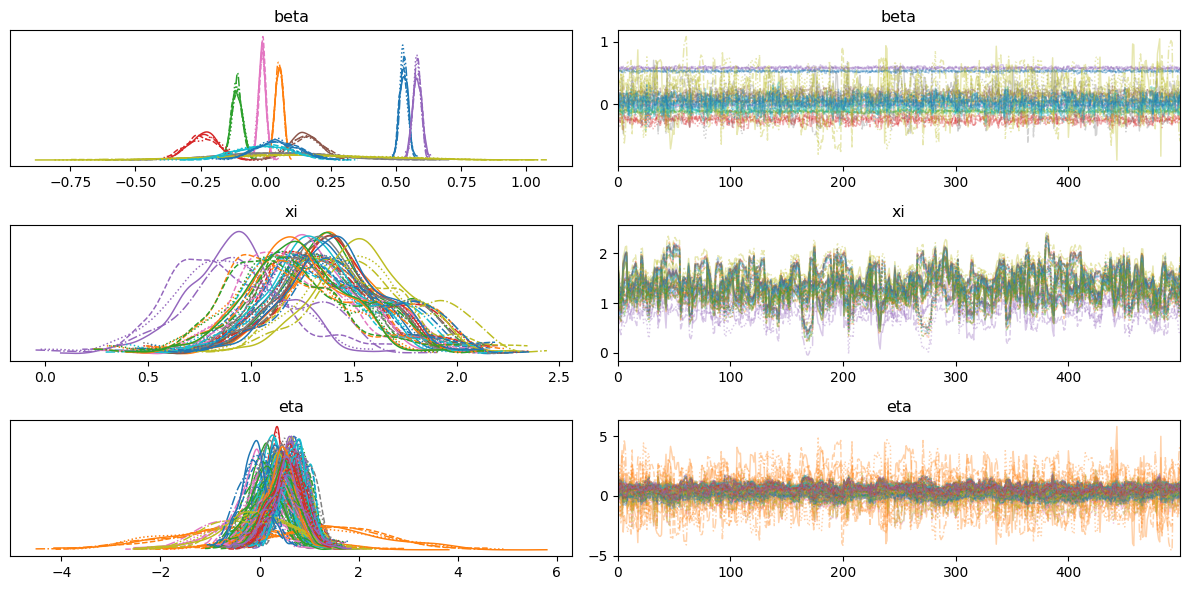

In [64]:
az.plot_trace(posterior_out120, var_names=['beta', 'xi', 'eta'], compact=True)
plt.tight_layout()
plt.show()

In [65]:
posterior_out120

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

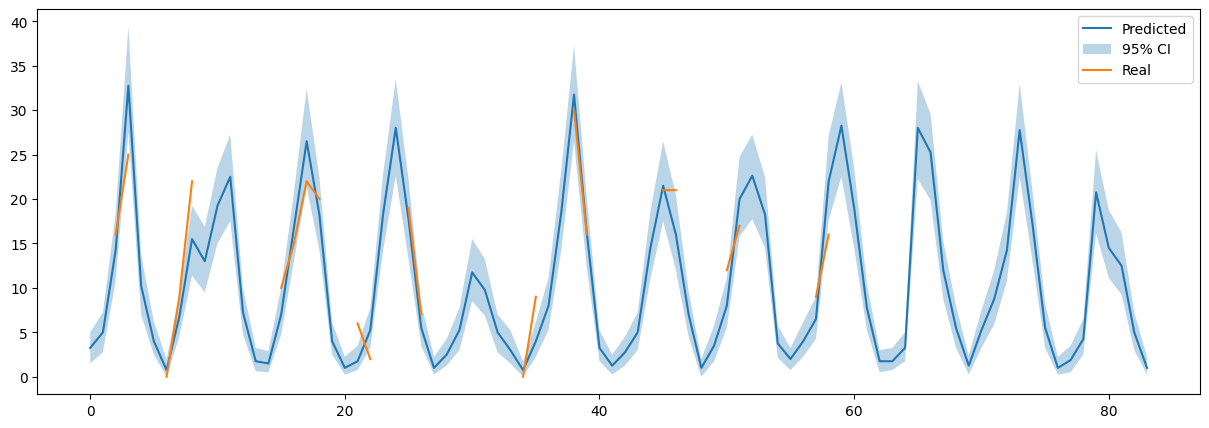

In [66]:
preds_y = posterior_out120['posterior']['y_pred'].mean(axis=0)
preds_y_miss = posterior_out120['posterior']['y_pred_miss'].mean(axis=0)

y_star = preds_y.median(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)

y_star_miss = preds_y_miss.median(axis=0)
y_star_up_miss = np.percentile(preds_y_miss, 97.5, axis=0)
y_star_low_miss = np.percentile(preds_y_miss, 2.5, axis=0)

# Recunstruct the original indexes
y_star_obs = pd.Series(y_star, index=Y_obs_index)
y_star_up_obs = pd.Series(y_star_up, index=Y_obs_index)
y_star_low_obs = pd.Series(y_star_low, index=Y_obs_index)

y_star_miss = pd.Series(y_star_miss, index=Y_miss_index)
y_star_up_miss = pd.Series(y_star_up_miss, index=Y_miss_index)
y_star_low_miss = pd.Series(y_star_low_miss, index=Y_miss_index)

# Add the missing values
y_star_total = pd.concat([y_star_obs, y_star_miss])
y_star_up_total = pd.concat([y_star_up_obs, y_star_up_miss])
y_star_low_total = pd.concat([y_star_low_obs, y_star_low_miss])

# Sort the values
y_star_total = y_star_total.sort_index()
y_star_up_total = y_star_up_total.sort_index()
y_star_low_total = y_star_low_total.sort_index()

# Plot the predictions with the real values skipping the plot of the NA values
Y_data = np.array(Y['Count_120'])
Y_data[rows_to_drop_Y] = np.nan
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_star_total[xx], label='Predicted')
plt.fill_between(xx, y_star_low_total[xx], y_star_up_total[xx], alpha=0.3, label='95% CI')
plt.plot(xx, Y_data[xx], label='Real')
plt.legend()
plt.show()


In [67]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y_obs['Count_120']) | (y_star_up < Y_obs['Count_120']))[0]
print(outliers)
print(outliers.shape)

[   1    4    5   10   11   15   17   20   22   23   26   28   30   34
   36   41   45   48   50   51   54   55   56   58   62   65   68   70
   71   73   74   76   81   82   93   94   95   97  100  101  102  103
  104  106  108  109  113  114  115  116  118  122  123  126  128  129
  130  131  137  140  142  144  146  147  150  152  154  155  157  158
  164  165  166  169  172  173  178  179  181  182  186  188  190  191
  193  195  196  197  198  201  202  203  204  206  207  210  212  214
  215  216  218  219  220  223  225  230  231  238  239  241  242  245
  246  247  248  250  251  254  255  259  260  266  269  274  278  279
  281  282  283  284  287  289  290  295  301  302  303  305  306  307
  308  309  310  311  312  315  316  319  321  324  325  330  331  334
  335  341  343  344  346  348  349  350  352  353  355  358  361  362
  365  367  369  371  373  374  377  378  380  381  382  384  386  389
  390  391  392  393  395  398  401  402  404  408  409  411  412  413
  414 

[   1   18   35  308  332  438  534  549  688  947  966 1285 1300 1304
 1334 1348 1349 1439 1489 1506 1552 1653 1802 1877 1887]
(25,)
[ 193  214  218  312  390  444  447  509  512  695  766  976 1046 1300
 1349 1356 1399 1400 1403 1497 1501 1506 1509 1617 1756]
(25,)


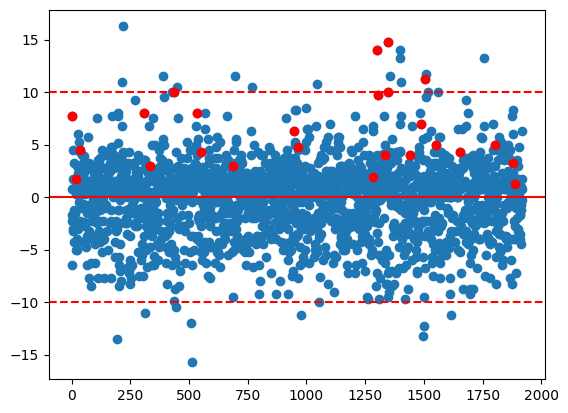

In [68]:
idx_over_max = np.where(y_star > max_month_obs)[0]
print(idx_over_max)
print(idx_over_max.shape)

res = y_star - Y_obs['Count_120']
residuals = np.abs(res)

res_over_10 = np.where(residuals > 10)[0]
print(res_over_10)
print(res_over_10.shape)

#plot these residuals
plt.scatter(np.arange(0, len(res)),res)
plt.scatter(idx_over_max, res[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.show()

In [76]:
mae = np.mean(residuals)
print(mae)
mse = np.mean(residuals**2)
print(mse)

<xarray.DataArray ()>
array(2.796875)
<xarray.DataArray ()>
array(13.52685547)


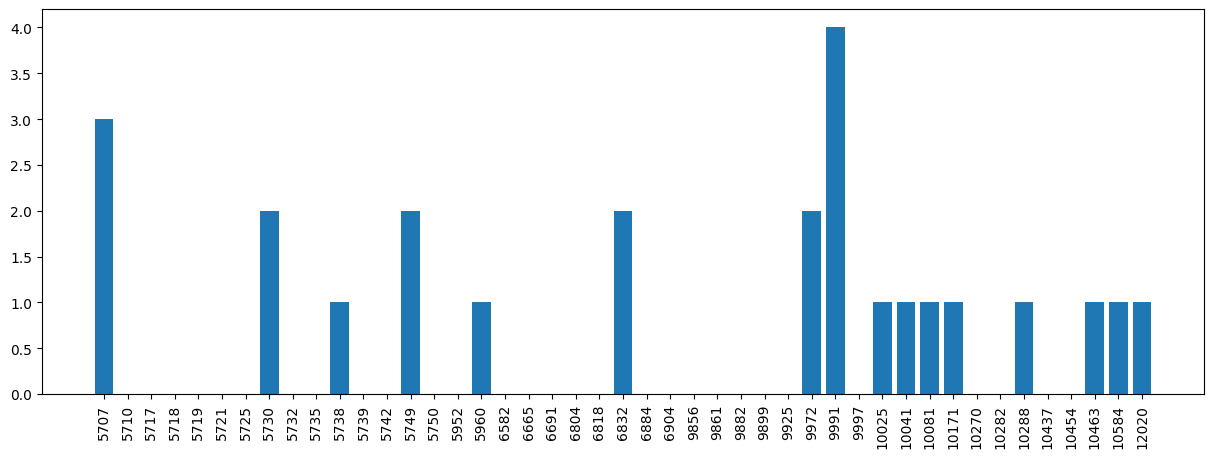

In [70]:
# Count how many outliers we have per station
outliers_per_station = pd.Series(np.zeros(45), index=stations_obs.unique())
for i in idx_over_max:
    outliers_per_station[stations_obs[i]] += 1
outliers_per_station = outliers_per_station.astype(int)
outliers_per_station.index = outliers_per_station.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_station.index, outliers_per_station)
plt.xticks(rotation=90)
plt.show()

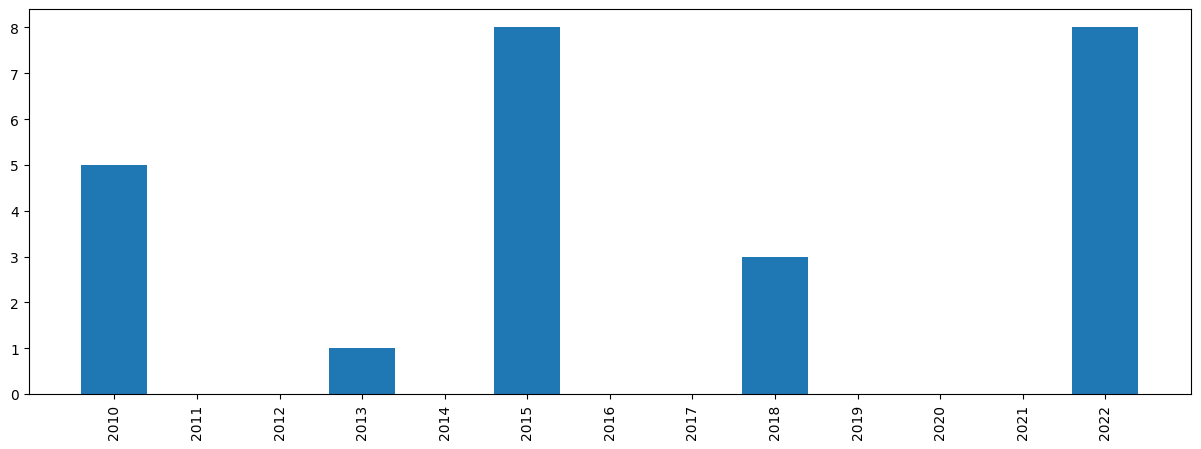

In [71]:
# Count how many outliers we have per year
outliers_per_year = pd.Series(np.zeros(13), index=years_raw_obs.unique())
for i in idx_over_max:
    outliers_per_year[years_raw_obs[i]] += 1
outliers_per_year = outliers_per_year.astype(int)
outliers_per_year.index = outliers_per_year.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_year.index, outliers_per_year)
plt.xticks(rotation=90)
plt.show()

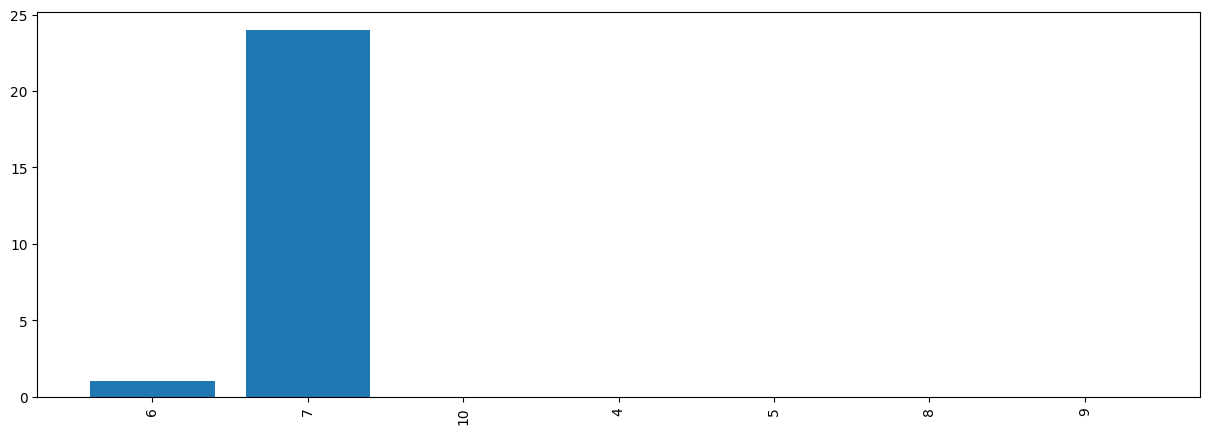

In [72]:
# Count how many outliers we have per month
outliers_per_month = pd.Series(np.zeros(7), index=months_raw_obs.unique())
for i in idx_over_max:
    outliers_per_month[months_raw_obs[i]] += 1
outliers_per_month = outliers_per_month.astype(int)
outliers_per_month.index = outliers_per_month.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_month.index, outliers_per_month)
plt.xticks(rotation=90)
plt.show()

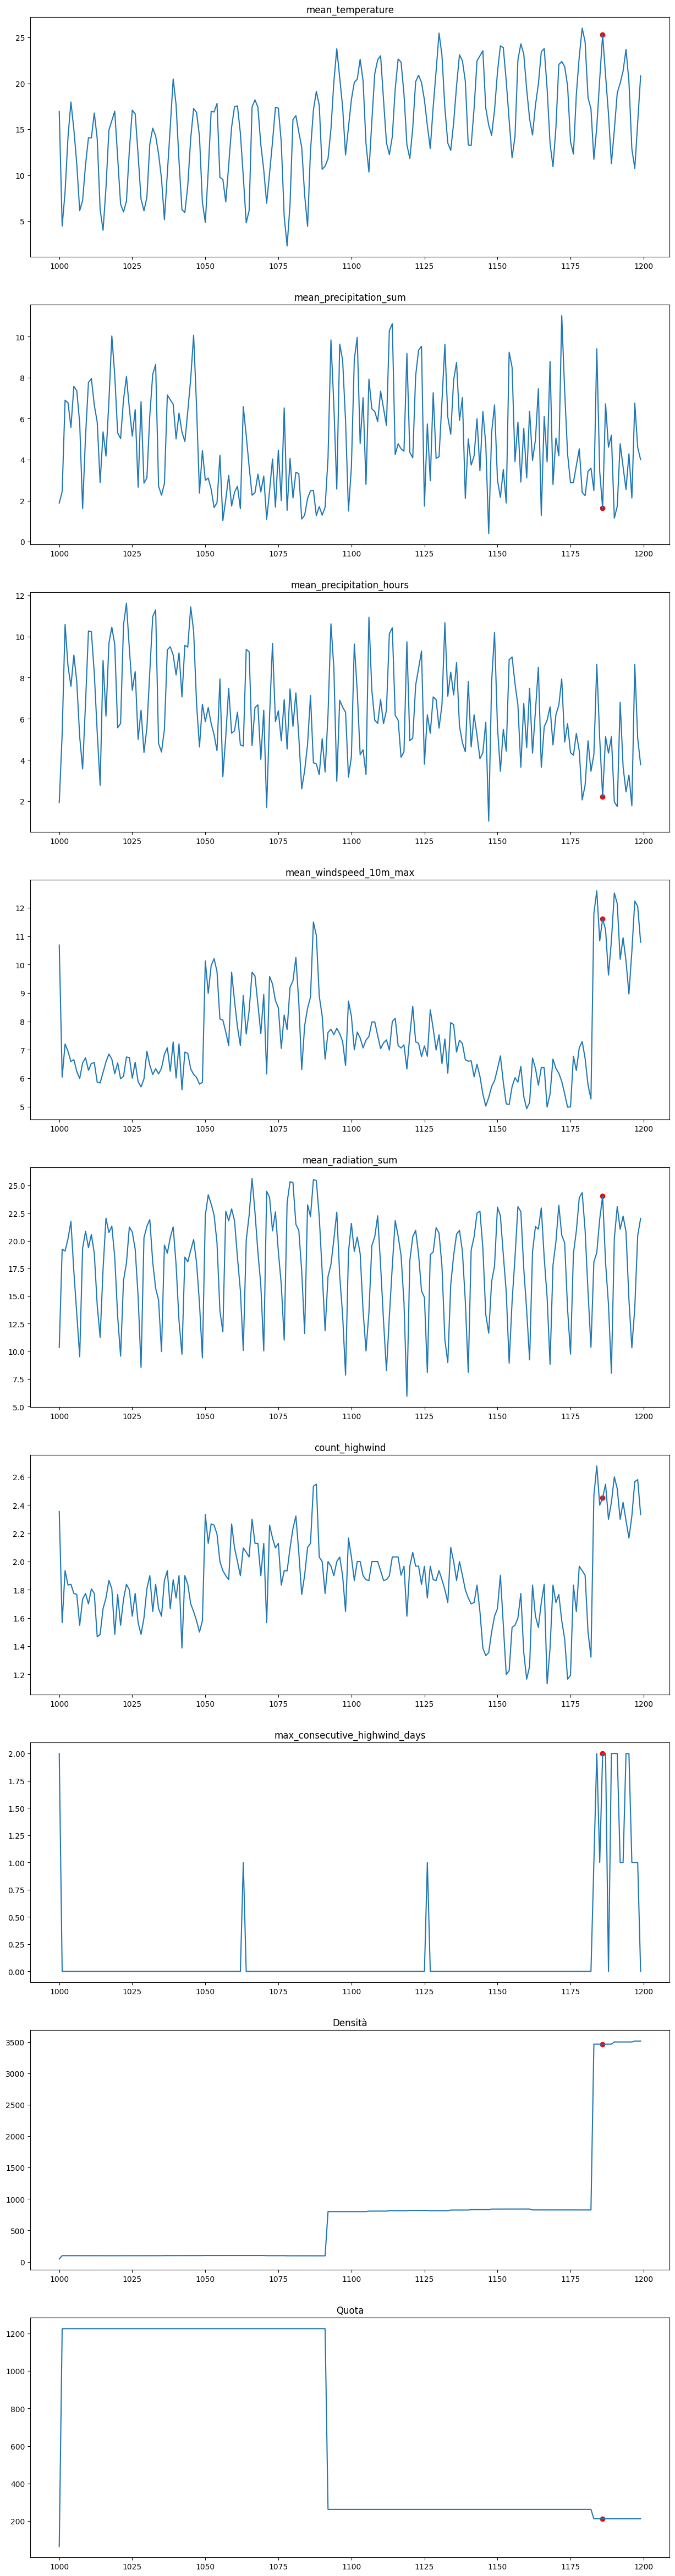

In [73]:
# Plotting covariates around the outliers
X_data = X.drop(['Year','Station','Month'], axis  = 1)
station_num_to_plot = -1 # Change this to plot different stations, -1 to choose manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
fig, axs = plt.subplots(9, 1, figsize=(15, 60))
for i in range(0,9):
    axs[i].plot(xx, X_data.iloc[:,i][xx])
    axs[i].scatter(np.intersect1d(X_obs_index[idx_over_max],xx), X_data.iloc[:,i][np.intersect1d(X_obs_index[idx_over_max],xx)], color='r')
    axs[i].set_title(X_data.columns[i])
plt.show()

[ 101  204  232  247  281  325  337  341  379  417  460  475  615  768
  964 1025 1086 1094 1109 1142 1224 1352 1377 1475 1555 1589 1726 1729
 1768 1810 1818 1856]
(32,)
[ 203  301  325  458  591  814 1014 1060 1085 1109 1219 1326 1354 1363
 1371 1375 1446 1471 1524 1546 1702 1714 1726 1781 1804 1894 1918]
(27,)


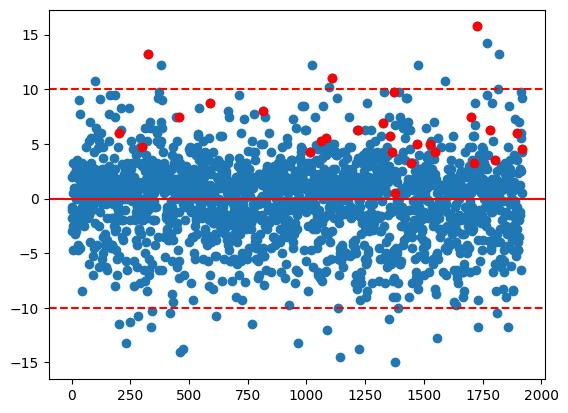

In [74]:
# Prediction error on the test set
res_test = y_star_total[rows_test_Y] - Y['Count_120'][rows_test_Y]
res_test = res_test.sort_index()
res_test = res_test.reset_index(drop=True)
residuals_test = np.abs(res_test)

res_over_10_test = np.where(residuals_test > 10)[0]
print(res_over_10_test)
print(res_over_10_test.shape)

test_over_max = np.where(y_star_total[rows_test_Y] > max_month_tot[rows_test_Y])[0]
print(test_over_max)
print(test_over_max.shape)

#plot these residuals
plt.scatter(np.arange(0, len(res_test)),res_test)
plt.scatter(test_over_max, res_test[test_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.show()

In [75]:
mae_test = np.mean(residuals_test)
print(mae_test)
mse_test = np.mean(residuals_test**2)
print(mse_test)

2.8984375
14.8158203125
